# Data Merge Project Script

This script handles merging cleaned versions of the AirBnB Toronto and Yelp Business datasets. For details on how I created those datasets refer to this notebook: http://localhost:8888/notebooks/Springboard/Springboard_Projects/Capstone/Scripts/1%20-%20Capstone_DataWrangling_Script.ipynb

In [1]:
#import libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
#allow all columns to be viewed:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
current_path = % pwd
#print(current_path)

In [3]:
#If current_path is in Scripts folder, 
#go up one level so we can open the data folder
if (current_path.rsplit('\\', 1)[1] == 'Scripts'):
    % cd ..
    #% pwd

D:\Coding Projects\Springboard\Springboard_Projects\Capstone


In [48]:
#Import data

#Read in AirBnB cleaned listing data for Toronto
path1='../Capstone/Data/listings_clean.csv'
abb = pd.read_csv(path1)

#Read in Yelp cleaned business data for Toronto
path2='../Capstone/Data/yelp_clean.csv'
yelp = pd.read_csv(path2)

print(abb.shape)
print(yelp.shape)

(16939, 232)
(13175, 10)


## Fix Missing Neighborhoods and Mismatches

The ultimate goal is to use the keep the AirBnB listings dataset and merge in for each listing the total number of businesses, their average star rating, and the number of reviews, for all Yelp businesses within 0.1 miles of the AirBnB listing. Without any other filtering this would involve comparing the lat/long of every single AirBnB listing (16,947) against every Yelp business (14,023). This could be very time-consuming. 

To limit the number of comparisons and make the process more manageable I plan to only compare listings in the same neighborhood, which is a variable in both datasets. There were a significant number of missing neighborhood values in each dataset, so my next step will be to use K Nearest Neighbors to predict those missing values so those records can be used. 

### Rename Mismatched Neighborhoods
First I will inspect the neighborhoods in each dataset and check how many match or do not match in each dataset. 

In [5]:
abb_hoods = pd.DataFrame(abb['neighbourhood'].value_counts().reset_index())
yelp_hoods = pd.DataFrame(yelp['neighborhood'].value_counts().reset_index())
print(abb_hoods.shape)
print(yelp_hoods.shape)
print(abb_hoods.head())
print(yelp_hoods.head())

(140, 2)
(113, 2)
                    index  neighbourhood
0        Downtown Toronto           2081
1  Entertainment District           1571
2                 Unknown            855
3                 Niagara            696
4              Willowdale            504
           index  neighborhood
0        Unknown          5320
1    Scarborough           846
2  Downtown Core           627
3      Etobicoke           585
4       Milliken           268


In [6]:
#Next check how many neighborhood matches there are between datasets:
match_hoods = pd.merge(abb_hoods, yelp_hoods, 
                       on=['index'], how='outer')

In [7]:
#Count records where there is no match on each side.
abb_nomatch = match_hoods.neighbourhood[match_hoods.neighborhood.isnull()]
print('There are ' + str(abb_nomatch.sum()) + ' AirBnB listings with no match in the Yelp data.')

yelp_nomatch = match_hoods.neighborhood[match_hoods.neighbourhood.isnull()]
print('There are ' + str(yelp_nomatch.sum()) + ' Yelp listings with no match in the AirBnB data.')


There are 9547.0 AirBnB listings with no match in the Yelp data.
There are 5528.0 Yelp listings with no match in the AirBnB data.


It seems there are quite a few mismatches. 9,554 out of approx. 17K records in the AirBnB dataset do not have a neighborhood match in the Yelp dataset, which is approximately 56%. On the other side 7,077 Yelp listings out of approx. 14K do not have a neighborhood match on the AirBnB side, which is around 50%. Eventually I will drop the Yelp records that don't have a match, but first I will manually inspect the names to see if there are any neighborhoods that are simply named differently in each dataset. 

In [8]:
#View matches and mismatches side by side. 
#neighbourhood column shows the count of records in the AirBnB dataset
#neighborhood (no "u") shows the count of records in the Yelp dataset. 
#NaN in neighbourhood column indicates a name that exists in Yelp but not AirBnB.
#NaN in neighborhood column indicates a name that exists in AirBnB but not Yelp. 
print(match_hoods.sort_values('index'))

                             index  neighbourhood  neighborhood
38                       Agincourt          102.0           NaN
95                       Alderwood           32.0           NaN
166                 Alexandra Park            NaN          50.0
107                       Amesbury           26.0           NaN
77                  Armour Heights           42.0           NaN
73                         Bayview           44.0           NaN
76                 Bayview Village           42.0          21.0
176           Beaconsfield Village            NaN          38.0
89                    Bedford Park           35.0           NaN
82                         Bendale           40.0           NaN
169                  Bickford Park            NaN          43.0
67                     Birch Cliff           49.0           NaN
215                      Birchwood            NaN           3.0
165             Bloor-West Village            NaN          50.0
175              Bloordale Village      

In [9]:
#Checking neighbourhood against neighbourhood_cleansed in the AirBnB dataset might also provide context
print(abb[['neighbourhood_cleansed', 'neighbourhood']].drop_duplicates().sort_values(by=['neighbourhood_cleansed', 'neighbourhood']))

                    neighbourhood_cleansed            neighbourhood
881                        Agincourt North                Agincourt
13882                      Agincourt North                  Unknown
322           Agincourt South-Malvern West                Agincourt
2170          Agincourt South-Malvern West             Malvern West
1476                             Alderwood                Alderwood
10872                            Alderwood                  Unknown
12325                                Annex                Casa Loma
1070                                 Annex         Downtown Toronto
2707                                 Annex  Palmerston/Little Italy
3488                                 Annex                 Rosedale
2                                    Annex                The Annex
463                                  Annex                  Unknown
256                                  Annex                Yorkville
308                      Banbury-Don Mills      

Inspecting the list shows a few obvious misnamings: The Beach in Yelp, The Beaches in AirBnB, for example. Where I see these I will correct the spelling in the Yelp dataset to match the AirBnB dataset. 

Others are not as obvious. The Yelp dataset has Scarborough neighborhood, while the AirBnB dataset has Scarborough City Centre, Scarborough Junction, and Scarborough Village. Consulting Wikipedia (https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto) it seems safe to group these together under Scarborough, along with other neighborhoods like Tam O'Shanter.

Before renaming anything, I will create a derived feature that tells me if the host lives in the same neighborhood as their listing by comparing host_neighbourhood to neighbourhood. This will not work after renaming neighborhoods. 

In [49]:
abb['host_lives_near_listing'] = abb['neighbourhood'] == abb['host_neighbourhood']

In [50]:
#Rename Scarborough Neighborhoods as Scarborough in AirBnB
abb.neighbourhood.replace(['Agincourt', 'Scarborough Village', 'Tam O\'Shanter', 
                          'Scarborough Junction', 'Scarborough City Centre', 'Bendale', 'Birch Cliff',
                          'Clairlea', 'Cliffcrest', 'Dover Park', 'Cliffside', 'Dorset Park', 'Eglinton East',
                          'Guildwood', 'Highland Creek', 'Ionview', 'L\'Amoreaux', 'Malvern', 'Malvern West',
                          'Morningside', 'Morningside Heights', 'Oakridge', 'Port Union', 'Rouge', 'West Hill',
                          'West Rouge', 'Wexford/Maryvale', 'Woburn', 'Manse Valley', 'Milliken'],
                        'Scarborough', inplace=True)

In [51]:
#Rename Etobicoke Neighborhoods as Etobicoke in AirBnB
abb.neighbourhood.replace(['Etobicoke West Mall', 'Alderwood', 'Eringate', 'Humber Valley', 'Islington', 'Long Branch',
                          'Mimico', 'Princess', 'Richview', 'Stonegate-Queensway', 'The Elms', 'The Kingsway', 
                           'The Westway', 'Thistletown', 'West Humber', 'Westmount'],
                        'Etobicoke', inplace=True)

In [52]:
#Rename Downtown Core Neighborhoods as Downtown Core in AirBnB
abb.neighbourhood.replace(['Downtown Toronto', 'Fashion District', 'Garden District', 'Saint Andrew/Windfields',
                          'Toronto Islands', 'Studio District'],
                        'Downtown Core', inplace=True)

In [53]:
#Rename East York neighborhoods as East York in AirBnB
abb.neighbourhood.replace(['Broadview North', 'Crescent Town', 'Old East York', 'Parkview', 'Thorncliffe Park',
                          'Flemingdon Park'],
                        'East York', inplace=True)

In [68]:
#Miscellaneous AirBnB Renamings
abb.neighbourhood.replace(['Bedford Park'],
                        'Lawrence Park', inplace=True)
abb.neighbourhood.replace(['Lawrence Park'],
                        'Yonge Eglinton', inplace=True)
abb.neighbourhood.replace(['Greek Town', 'The Pocket'],
                        'Greektown', inplace=True)
abb.neighbourhood.replace(['Humberlea'],
                        'Pelmo Park', inplace=True)
abb.neighbourhood.replace(['Markland Woods'],
                        'Markland Wood', inplace=True)
abb.neighbourhood.replace(['South Hill/Rathnelly'],
                        'South Hill', inplace=True)
abb.neighbourhood.replace(['Danforth Village', 'Woodbine/Lumsden'],
                        'The Danforth', inplace=True)
abb.neighbourhood.replace(['Bayview', 'Henry Farm', 'Don Valley Village', 'Hillcrest Village'],
                        'Bayview Village', inplace=True)
abb.neighbourhood.replace(['Cedarvale Humewood'],
                        'Wychwood', inplace=True)
abb.neighbourhood.replace(['Financial District', 'Harbourfront'],
                        'Entertainment District', inplace=True)
abb.neighbourhood.replace(['Forest Hill', 'Lytton Park'],
                        'Yonge Eglinton', inplace=True)
abb.neighbourhood.replace(['Greenwood-Coxwell'],
                        'Greektown', inplace=True)
abb.neighbourhood.replace(['Runnymede', 'Lambton Baby Point'],
                        'High Park North', inplace=True)
abb.neighbourhood.replace(['Leaside', 'Sunnybrook'],
                        'Davisville', inplace=True)
abb.neighbourhood.replace(['Markland Wood'],
                        'Etobicoke', inplace=True)
abb.neighbourhood.replace(['Newtonbrook'],
                        'Willowdale', inplace=True)
abb.neighbourhood.replace(['Woodbine Corridor'],
                        'The Beaches', inplace=True)
abb.neighbourhood.replace(['Wychwood Park', 'Fairbank', 'Oakwood'],
                        'Wychwood', inplace=True)
abb.neighbourhood.replace(['Armour Heights', ],
                        'Hogg\'s Hollow', inplace=True)

In [55]:
#Rename Downtown Core Neighborhoods as Downtown Core in Yelp
yelp.neighborhood.replace(['Alexandra Park', 'Chinatown', 'Christie Pits', 'Church-Wellesley Village', 'City Place',
                          'Discovery District', 'Distillery District', 'Financial District', 'Queen Street West', 'Hanlan',
                          'Koreatown', 'Leslieville', 'Ryerson', 'University of Toronto'],
                        'Downtown Core', inplace=True)

In [56]:
#Rename Scarborough Neighborhoods as Scarborough in Yelp
yelp.neighborhood.replace(['Milliken', 'Cedar Valley'],
                         'Scarborough', inplace=True)

In [57]:
#Rename Palmerston/Little Italy neighborhoods as Palmerston/Little Italy in Yelp
yelp.neighborhood.replace(['Palmerston', 'Little Italy', 'Seaton Village'],
                        'Palmerston/Little Italy', inplace=True)

In [67]:
#Miscellaneous Yelp Renamings
yelp.neighborhood.replace(['Dovercourt'],
                        'Dovercourt Park', inplace=True)
yelp.neighborhood.replace(['High Park'],
                        'High Park North', inplace=True)
yelp.neighborhood.replace(['Mount Pleasant and Davisville'],
                        'Davisville', inplace=True)
yelp.neighborhood.replace(['St. Lawrence'],
                        'Saint Lawrence', inplace=True)
yelp.neighborhood.replace(['The Beach'],
                        'The Beaches', inplace=True)
yelp.neighborhood.replace(['Trinity Bellwoods'],
                        'Trinity-Bellwoods', inplace=True)
yelp.neighborhood.replace(['Yonge and St. Clair', 'Moore Park'],
                        'Deer Park', inplace=True)
yelp.neighborhood.replace(['Yonge and Eglinton'],
                        'Yonge Eglinton', inplace=True)
yelp.neighborhood.replace(['Beaconsfield Village', 'Ossington Strip', 'Lisgar'],
                        'Little Portugal', inplace=True)
yelp.neighborhood.replace(['Bloor-West Village'],
                        'Swansea', inplace=True)
yelp.neighborhood.replace(['Corso Italia'],
                        'Wychwood', inplace=True)
yelp.neighborhood.replace(['Bloordale Village'],
                        'Dovercourt Park', inplace=True)
yelp.neighborhood.replace(['Brockton Village', 'Lakeview', 'Bickford Park'],
                        'Palmerston/Little Italy', inplace=True)
yelp.neighborhood.replace(['Harbourfront'],
                        'Entertainment District', inplace=True)
yelp.neighborhood.replace(['Liberty Village', 'West Queen West'],
                        'Niagara', inplace=True)
yelp.neighborhood.replace(['Markland Wood', 'Burnhamthorpe'],
                        'Etobicoke', inplace=True)
yelp.neighborhood.replace(['Summer Hill'],
                        'Yorkville', inplace=True)
yelp.neighborhood.replace(['Upper Beach'],
                        'The Beaches', inplace=True)
yelp.neighborhood.replace(['West Don Lands'],
                        'Corktown', inplace=True)
yelp.neighborhood.replace(['Birchwood'],
                        'Hogg\'s Hollow', inplace=True)
yelp.neighborhood.replace(['Box Grove', 'Brown\'s Corners', 'Buttonville'],
                        'Markham Village', inplace=True)
yelp.neighborhood.replace(['Cooksville', 'East Credit', 'Erin Mills', 'Erindale',
                          'Lorne Park'],
                        'Mississauga', inplace=True)
yelp.neighborhood.replace(['Cornell'],
                        'Mount Dennis', inplace=True)
yelp.neighborhood.replace(['Lawrence Park'],
                        'Yonge Eglinton', inplace=True)

In [69]:
#Check matches again
abb_hoods = pd.DataFrame(abb['neighbourhood'].value_counts().reset_index())
yelp_hoods = pd.DataFrame(yelp['neighborhood'].value_counts().reset_index())
match_hoods = pd.merge(abb_hoods, yelp_hoods, 
                       on=['index'], how='outer')
#Count records where there is no match on each side.
abb_nomatch = match_hoods.neighbourhood[match_hoods.neighborhood.isnull()]
print('There are ' + str(abb_nomatch.sum()) + ' AirBnB listings with no match in the Yelp data.')

yelp_nomatch = match_hoods.neighborhood[match_hoods.neighbourhood.isnull()]
print('There are ' + str(yelp_nomatch.sum()) + ' Yelp listings with no match in the AirBnB data.')

print(match_hoods.sort_values('index'))

There are 0 AirBnB listings with no match in the Yelp data.
There are 0 Yelp listings with no match in the AirBnB data.
                      index  neighbourhood  neighborhood
14          Bayview Village            320            21
24              Cabbagetown            217            41
40                Casa Loma             26             6
39                 Corktown             34            99
12               Davisville            333           110
33                Deer Park             63            52
22          Dovercourt Park            223            75
34                Downsview             62            47
0             Downtown Core           2931          1599
27           Dufferin Grove            166            55
26                East York            212            74
1    Entertainment District           1909           266
5                 Etobicoke            729           596
20                Greektown            234            93
21          High Park Nor

In [64]:
#Drop records in each dataset where no neighborhood match exists
#This will drop 6% of AirBnB listings, approx 1000 out of 17000 records. I could impute the Yelp metrics for these
#... but I don't think it would be representative to impute records for the suburbs based on downtown.
#Only 7 Yelp records are ummatched which is a small number to drop.
abb_drop_hoods = ['Amesbury', 'Armour Heights', 'Clanton Park', 'Don Mills', 'Glen Park',
                  'Humber Summit', 'Humbermede', 'Jane and Finch', 'Keelesdale', 
                  'Mount Olive', 'North Park', 'Nortown', 'Oakwood', 'Parkwoods', 'Pellam Park', 'Pelmo Park',
                  'Pleasant View', 'Rockcliffe Smythe','Victoria Village', 'Westminster/Branson', 
                  'Weston', 'York University Heights']
                  
yelp_drop_hoods = ['Edgeley', 'Erin Mills', 'Langstaff', 'Meadowvale Village', 'Mississauga Valley',
                  'Thornhill', 'Thornhill Woods', 'Dixie', 'Greensborough', 'Kleinburg', 'Langstaff',
                  'Malton', 'Maple', 'Markham Village', 'Meadowvale Village', 'Mississauga',
                  'Mississauga Valley', 'Old Malton Village', 'Pine Grove', 'Port Credit',
                  'Rockwood Village', 'Streetsville', 'Summerville',
                  'Unionville', 'Unionville Mainstreet', 'Victory Village', 'Ridgewood',
                  'Woodbridge', 'Clarkson', 'Mineola']

abb = abb[~abb['neighbourhood'].isin(abb_drop_hoods)]
yelp = yelp[~yelp['neighborhood'].isin(yelp_drop_hoods)]

### Imputing Missing Neighborhoods with KNN
Previously in the Data Wrangling script I renamed missing Neighborhood values with "Unknown". I now plan to predict the value for those neighborhoods by using K Nearest Neighbors. First I will create a single data frame with the Neighborhoods and Lat/Longs from both the AirBnB and Yelp datasets. Then I will split the data frame into "train" and "test" datasets. The test dataset will include all neighborhoods with the value "Unknown". Next I will run K Nearest Neighbors on the train dataset and use the resulting model to predict the values in the test dataset. 


In [70]:
#Create dfs with neighborhood, lat, long from each dataset
abb_hoods_df = abb[['id', 
                    'neighbourhood', 'latitude', 'longitude']]
abb_hoods_df = abb_hoods_df.rename(columns={'neighbourhood':'neighborhood'})
print(abb_hoods_df.head())
yelp_hoods_df = yelp[['business_id', 
                      'neighborhood', 'latitude', 'longitude']]
print(yelp_hoods_df.head())

      id       neighborhood   latitude  longitude
0   1419    Little Portugal  43.646168 -79.424510
1  10314          Riverdale  43.670186 -79.335848
2  12604          The Annex  43.667241 -79.415978
3  17936  Kensington Market  43.656400 -79.403295
4  23691           Wychwood  43.696017 -79.454683
              business_id   neighborhood   latitude  longitude
1  5J3b7j3Fzo9ISjChmoUoUA       Wychwood  43.681328 -79.427884
2  Be7Mwq06nf1eNLblo1ekow      Downsview  43.731316 -79.465133
3  RJEtBRLJmmji_QoqS6ysjg  Downtown Core  43.667749 -79.396167
4  YIez_A3WOt9J2SXN7OMa2Q        Unknown  43.745928 -79.324623
5  j7yI3qYRsbGBUv9rShLCaQ        Unknown  43.776719 -79.603614


In [71]:
neighborhoods_df = pd.concat([abb_hoods_df, yelp_hoods_df], sort=True)
neighborhoods_df.shape

(27956, 5)

In [72]:
#Remove Unknown neighborhoods
neighborhoods_df = neighborhoods_df[neighborhoods_df['neighborhood'] != 'Unknown']
print(neighborhoods_df.head())
print(neighborhoods_df.shape)

  business_id       id   latitude  longitude       neighborhood
0         NaN   1419.0  43.646168 -79.424510    Little Portugal
1         NaN  10314.0  43.670186 -79.335848          Riverdale
2         NaN  12604.0  43.667241 -79.415978          The Annex
3         NaN  17936.0  43.656400 -79.403295  Kensington Market
4         NaN  23691.0  43.696017 -79.454683           Wychwood
(21781, 5)


In [73]:
#Convert neighborhoods to numeric for prediction
le = preprocessing.LabelEncoder()
le.fit(neighborhoods_df['neighborhood'].astype(str)) #fit to list of all neighborhoods to ensure all possible values are encoded

LabelEncoder()

In [74]:
#Create train/test split from neighborhoods_df
x = neighborhoods_df[['latitude', 'longitude']]
y = neighborhoods_df[['neighborhood', 'business_id', 'id']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [75]:
y_train['neighborhood'] = le.transform(y_train['neighborhood'].astype(str))
y_test['neighborhood'] = le.transform(y_test['neighborhood'].astype(str))
#print(y_train)
#Code below converts back to original values
#print("")
#y_train['neighborhood'] = le.inverse_transform(y_train['neighborhood'])
#print(y_train)

C:\Users\jshka\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\jshka\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [76]:
# Scale lat/long before modeling
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [77]:
# Run K Means on training set
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train.loc[:, 'neighborhood'].values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [78]:
#Make predictions
y_pred = classifier.predict(x_test)

In [79]:
# Evaluate model
print(confusion_matrix(y_test.loc[:, 'neighborhood'], y_pred))
print(classification_report(y_test.loc[:, 'neighborhood'], y_pred))

[[ 68   0   0 ...   0   0   0]
 [  0  48   0 ...   0   0   0]
 [  0   0   3 ...   4   0   0]
 ...
 [  0   0   1 ... 117   0   0]
 [  0   0   0 ...   2  58   0]
 [  0   0   0 ...   0   0  63]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        68
          1       0.89      0.94      0.91        51
          2       0.75      0.43      0.55         7
          3       0.92      0.55      0.69        22
          4       0.96      0.92      0.94       104
          5       0.97      1.00      0.98        30
          6       0.87      0.91      0.89        76
          7       1.00      1.00      1.00        23
          8       0.93      0.96      0.94       878
          9       0.85      0.80      0.82        35
         10       0.95      0.91      0.93        69
         11       0.98      0.95      0.96       424
         12       1.00      1.00      1.00       268
         13       0.78      0.91      0.84        54
         14 

The above predictions were great, but I want to confirm I used the best value for K. Possibly setting 5 as the n_neighbors parameter was not the best value, so I will try  the below loop to test multiple values and use a plot to determine the best outcome. 

In [80]:
error = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(x_train, y_train.loc[:, 'neighborhood'].values.ravel())
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test.loc[:, 'neighborhood']))

Text(0,0.5,'Mean Error')

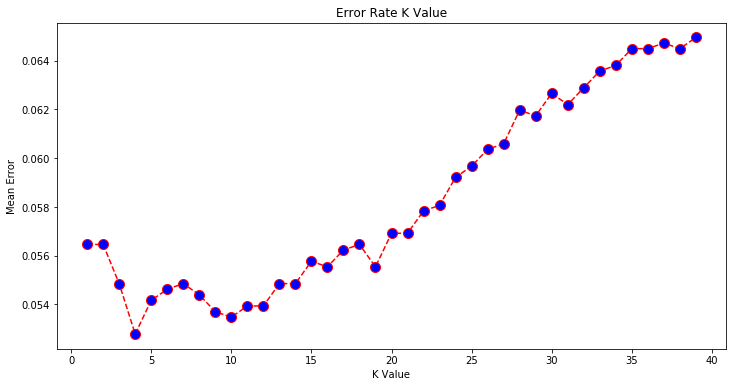

In [81]:
#Plot the errors against the various k values
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
        markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

K=4 seems to do the best with around 0.05 mean error. I will change the parameter and run it one more time, then use the model to predict the "Unknown" values. 

In [82]:
# Run K Means on training set, this time setting n_neighbors to optimal value
classifier = KNeighborsClassifier(n_neighbors=4, weights='distance')
classifier.fit(x_train, y_train.loc[:, 'neighborhood'].values.ravel())

#Make predictions
y_pred = classifier.predict(x_test)

### Predict neighborhood in AirBnB dataset

In [83]:
#Use the model to predict the Unknown neighborhoods in AirBnB data.
abb_copy = abb.loc[abb['neighbourhood']=='Unknown', ['id', 'latitude', 'longitude', 'neighbourhood']]

#Transform
abb_copy[['latitude', 'longitude']] = scaler.transform(abb_copy[['latitude', 'longitude']])

#Create a new column containing transformed values of neighbourhood
abb_copy['neighborhood'] = None

In [84]:
#Predict values of neighborhood
abb_copy['neighborhood'] = classifier.predict(abb_copy[['latitude', 'longitude']])

#Convert neighborhood back to original text values (instead of numeric)
abb_copy['neighborhood'] = le.inverse_transform(abb_copy['neighborhood'])

C:\Users\jshka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [85]:
#Merge predicted neighborhood back into abb
abb = pd.merge(abb, abb_copy, how='outer', on='id')

In [86]:
#Replace unknown values
abb.loc[abb['neighbourhood_x']=='Unknown', 'neighbourhood_x'] = abb.loc[abb['neighbourhood_x']=='Unknown', 'neighborhood']

In [87]:
#Drop unecessary columns
abb.drop(columns=['latitude_y', 'longitude_y', 'neighbourhood_y', 'neighborhood'], inplace=True)
abb.head()

id                         listing_url host_response_time  \
0   1419   https://www.airbnb.com/rooms/1419     within an hour   
1  10314  https://www.airbnb.com/rooms/10314     within an hour   
2  12604  https://www.airbnb.com/rooms/12604     within an hour   
3  17936  https://www.airbnb.com/rooms/17936     within an hour   
4  23691  https://www.airbnb.com/rooms/23691     within an hour   

   host_response_rate host_is_superhost host_neighbourhood    neighbourhood_x  \
0                 0.0                 f   Commercial Drive    Little Portugal   
1                 0.0                 f          Riverdale          Riverdale   
2                 0.0                 f          The Annex          The Annex   
3               100.0                 t  Kensington Market  Kensington Market   
4               100.0                 t           Fairbank           Wychwood   

  neighbourhood_cleansed  latitude_x  longitude_x property_type  \
0        Little Portugal   43.646168   -79.424510         House   
1        South Riverdale   43.670186   -79.335848         House   
2                  Annex   43.667241   -79.415978         House   
3   Kensington-Chinatown   43.656400   -79.403295     Apartment   
4   Briar Hill-Belgravia   43.696017   -79.454683         House   

         room_type  accommodates  bathrooms  bedrooms  beds       bed_type  \
0  Entire home/apt           6.0        2.0       3.0   4.0       Real Bed   
1     Private room           2.0        1.0       1.0   1.0       Real Bed   
2     Private room           1.0        1.5       1.0   1.0  Pull-out Sofa   
3     Private room           4.0        1.0       1.0   2.0       Real Bed   
4     Private room           2.0        1.0       1.0   1.0       Real Bed   

                                           amenities  price  security_deposit  \
0  {TV,Internet,Wifi,"Air conditioning",Kitchen,"...  470.0            1000.0   
1  {Wifi,"Air conditioning",Kitchen,"Free parking...   69.0               0.0   
2  {Internet,Wifi,"Pets live on this property",Ca...   65.0             130.0   
3  {TV,Internet,Wifi,"Air conditioning",Kitchen,"...   99.0             300.0   
4  {Internet,Wifi,"Air conditioning",Kitchen,"Fre...   70.0               0.0   

   cleaning_fee  guests_included  extra_people  minimum_nights  \
0         150.0              1.0           0.0             4.0   
1           0.0              2.0          20.0             1.0   
2          26.0              1.0          20.0             1.0   
3          80.0              1.0          20.0             2.0   
4           0.0              2.0          25.0             1.0   

  calendar_updated  availability_30  availability_60  availability_90  \
0     6 months ago                0                0                0   
1    11 months ago                0                0               21   
2        yesterday                0                0                0   
3       4 days ago                5                5               23   
4            today                0               10               40   

   availability_365 instant_bookable          cancellation_policy  \
0                 0                f  strict_14_with_grace_period   
1               296                f                     moderate   
2                 0                f                     moderate   
3                23                f  strict_14_with_grace_period   
4               315                t  strict_14_with_grace_period   

   reviews_per_month  square_feet_notNA  monthly_price_notNA  \
0               0.19               True                False   
1               0.71              False                 True   
2               0.00               True                 True   
3               1.18              False                 True   
4               2.02              False                 True   

   weekly_price_notNA  bathrooms_notNA  beds_notNA  bedrooms_notNA  \
0                True             True        True 

In [88]:
#Rename fields changed by merge
abb = abb.rename(columns={'neighbourhood_x':'neighborhood', 'latitude_x':'latitude', 
                          'longitude_x':'longitude'})

### Predict neighborhood in Yelp dataset

In [89]:
#Use the model to predict the Unknown neighborhoods in Yelp data.
yelp_copy = yelp.loc[yelp['neighborhood']=='Unknown', ['business_id', 'latitude', 'longitude', 'neighborhood']]

#Transform
yelp_copy[['latitude', 'longitude']] = scaler.transform(yelp_copy[['latitude', 'longitude']])

#Create a new column containing transformed values of neighbourhood
yelp_copy['neighborhood'] = None

In [90]:
#Predict values of neighborhood
yelp_copy['neighborhood'] = classifier.predict(yelp_copy[['latitude', 'longitude']])

#Convert neighborhood back to original text values (instead of numeric)
yelp_copy['neighborhood'] = le.inverse_transform(yelp_copy['neighborhood'])

C:\Users\jshka\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [91]:
#Merge predicted neighborhood back into yelp
yelp = pd.merge(yelp, yelp_copy, how='outer', on='business_id')

In [92]:
yelp.head()

business_id        city  latitude_x  longitude_x neighborhood_x  \
0  5J3b7j3Fzo9ISjChmoUoUA     Toronto   43.681328   -79.427884       Wychwood   
1  Be7Mwq06nf1eNLblo1ekow  North York   43.731316   -79.465133      Downsview   
2  RJEtBRLJmmji_QoqS6ysjg     Toronto   43.667749   -79.396167  Downtown Core   
3  YIez_A3WOt9J2SXN7OMa2Q     Toronto   43.745928   -79.324623        Unknown   
4  j7yI3qYRsbGBUv9rShLCaQ  Woodbridge   43.776719   -79.603614        Unknown   

   review_count  stars     city-state  is_restaurant  is_bar  latitude_y  \
0            23    4.0     Toronto-ON           True   False         NaN   
1             5    2.5  North York-ON           True   False         NaN   
2             3    4.5     Toronto-ON          False    True         NaN   
3           105    4.0     Toronto-ON           True   False    1.388884   
4            28    3.0  Woodbridge-ON           True   False    2.018737   

   longitude_y neighborhood_y  
0          NaN            NaN  
1          NaN            NaN  
2          NaN            NaN  
3     1.013310    Scarborough  
4    -3.136048      Etobicoke

In [93]:
#Replace unknown values
yelp.loc[yelp['neighborhood_x']=='Unknown', 'neighborhood_x'] = yelp.loc[yelp['neighborhood_x']=='Unknown', 'neighborhood_y']

In [94]:
#Drop unecessary columns
yelp.drop(columns=['latitude_y', 'longitude_y', 'neighborhood_y'], inplace=True)
yelp.head()

business_id        city  latitude_x  longitude_x neighborhood_x  \
0  5J3b7j3Fzo9ISjChmoUoUA     Toronto   43.681328   -79.427884       Wychwood   
1  Be7Mwq06nf1eNLblo1ekow  North York   43.731316   -79.465133      Downsview   
2  RJEtBRLJmmji_QoqS6ysjg     Toronto   43.667749   -79.396167  Downtown Core   
3  YIez_A3WOt9J2SXN7OMa2Q     Toronto   43.745928   -79.324623    Scarborough   
4  j7yI3qYRsbGBUv9rShLCaQ  Woodbridge   43.776719   -79.603614      Etobicoke   

   review_count  stars     city-state  is_restaurant  is_bar  
0            23    4.0     Toronto-ON           True   False  
1             5    2.5  North York-ON           True   False  
2             3    4.5     Toronto-ON          False    True  
3           105    4.0     Toronto-ON           True   False  
4            28    3.0  Woodbridge-ON           True   False

In [95]:
#Rename fields changed by merge
yelp = yelp.rename(columns={'neighborhood_x':'neighborhood', 'latitude_x':'latitude', 
                          'longitude_x':'longitude'})

## Merge abb and yelp datasets by computing distance

In [96]:
#Function to compute distance between two lat/longs
#Adapted from: 
#https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
from math import sin, cos, sqrt, atan2, radians

def compute_distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [97]:
#Make df that’s columns airbnb_id, neighborhood, lat, long
abb_hoods = abb[['id', 'neighborhood', 'latitude', 'longitude']]
abb_hoods.head()

id       neighborhood   latitude  longitude
0   1419    Little Portugal  43.646168 -79.424510
1  10314          Riverdale  43.670186 -79.335848
2  12604          The Annex  43.667241 -79.415978
3  17936  Kensington Market  43.656400 -79.403295
4  23691           Wychwood  43.696017 -79.454683

In [100]:
#Make df that's columns business_id, neighborhood, number of reviews, average star rating, lat, long from Yelp
yelp_hoods = yelp[['business_id', 'neighborhood', 'latitude', 
                      'longitude', 'review_count', 'stars']]
yelp_hoods.head()

business_id   neighborhood   latitude  longitude  review_count  \
0  5J3b7j3Fzo9ISjChmoUoUA       Wychwood  43.681328 -79.427884            23   
1  Be7Mwq06nf1eNLblo1ekow      Downsview  43.731316 -79.465133             5   
2  RJEtBRLJmmji_QoqS6ysjg  Downtown Core  43.667749 -79.396167             3   
3  YIez_A3WOt9J2SXN7OMa2Q    Scarborough  43.745928 -79.324623           105   
4  j7yI3qYRsbGBUv9rShLCaQ      Etobicoke  43.776719 -79.603614            28   

   stars  
0    4.0  
1    2.5  
2    4.5  
3    4.0  
4    3.0

In [101]:
#merge on neighborhood (the two dfs created above)
merge = pd.merge(abb_hoods, yelp_hoods, how='inner', on='neighborhood', suffixes = ('_abb', '_yelp'))
merge.shape

(13376562, 9)

The resulting dataset has 13,376,562 rows. This was expected as I am joining datasets with a many to many relationship. For each AirBnB listing I pulled in all Yelp businesses with a matching neighborhood, so the Yelp businesses are repeated many times. The dataset would have been much larger (potentially up to 200+ million rows) if I had not matched on neighborhood and compared every AirBnB listing to every Yelp listing. Cleaning up the neighborhood names to increase matches helped too.

In [102]:
#apply function to generate distance
merge['distance'] = list(map(compute_distance, merge['latitude_abb'], 
                            merge['longitude_abb'], merge['latitude_yelp'],
                            merge['longitude_yelp']))

In [103]:
#Output full merge dataframe to a pickle file for later re-use
merge.to_pickle('full_merge.pickle')

In [104]:
merge.loc[merge['distance']>0].head()

id     neighborhood  latitude_abb  longitude_abb             business_id  \
0  1419  Little Portugal     43.646168      -79.42451  s8-aBYSaPLR8wbfmnkqGWw   
1  1419  Little Portugal     43.646168      -79.42451  DM6SwVs5ksGe9mWKO94Q0A   
2  1419  Little Portugal     43.646168      -79.42451  a9sK9Ma4kIkN0Zpu0SSAtA   
3  1419  Little Portugal     43.646168      -79.42451  g4rBVDdbeDPKnJiNhNWgSQ   
4  1419  Little Portugal     43.646168      -79.42451  8al-XRt5nuIize8_STWffQ   

   latitude_yelp  longitude_yelp  review_count  stars   distance  
0      43.610812      -79.748986            11    3.5  26.418342  
1      43.649112      -79.420954            51    3.5   0.434949  
2      43.596900      -79.785846            17    1.5  29.606594  
3      43.574035      -79.739762             3    4.0  26.626706  
4      43.643191      -79.423903            53    3.5   0.334715

Now that I have computed distance between each AirBnB listing and all Yelp businesses in the same neighborhood, I want to create two sets of features: number of businesses, number of reviews, and average star rating, for all businesses within .1 and .5 miles. The end result should be 6 new variables.

First I need to create two new dataframes - one containing all records from merge where distance is <= .1, the other where distance is <= .5.

In [105]:
#filter for distance < .1
merge_1 = merge[merge['distance']<=.1]
#filter for distance < .5
merge_5 = merge[merge['distance']<=.5]
print(merge_1.shape)
print(merge_5.shape)

(44667, 10)
(787058, 10)


In [106]:
#For each dataset, group by airbnb_id with count to get number of businesses in that distance 
#Also avg. star rating and number of reviews
#For everything within .1 mile:
merge_group_1 = merge_1.groupby(['id']).agg({'business_id':'count',
                                                        'review_count':'sum',
                                                        'stars':'mean'})
merge_group_1 = merge_group_1.rename(columns={'business_id':'yelp_bus_count_1', 
                                          'review_count':'yelp_bus_total_reviews_1', 
                                          'stars':'yelp_bus_avg_rating_1'})

#For everything within .5 mile:
merge_group_5 = merge_5.groupby(['id']).agg({'business_id':'count',
                                                        'review_count':'sum',
                                                        'stars':'mean'})
merge_group_5 = merge_group_5.rename(columns={'business_id':'yelp_bus_count_5', 
                                          'review_count':'yelp_bus_total_reviews_5', 
                                          'stars':'yelp_bus_avg_rating_5'})


In [107]:
#Merge merge_group_1 and merge_group_5 together
merge_both = pd.merge(merge_group_1, merge_group_5, how='right', on='id')
merge_both.head()

yelp_bus_count_1  yelp_bus_total_reviews_1  yelp_bus_avg_rating_1  \
id                                                                         
1419                1.0                      66.0               3.500000   
17936              20.0                    1440.0               3.650000   
42892               2.0                      18.0               3.500000   
44452              11.0                     222.0               3.136364   
44469              13.0                     232.0               3.115385   

       yelp_bus_count_5  yelp_bus_total_reviews_5  yelp_bus_avg_rating_5  
id                                                                        
1419                116                      8634               3.758621  
17936               160                     11434               3.715625  
42892                83                      3378               3.162651  
44452                16                       255               3.250000  
44469                16                       255               3.250000

In [108]:
#Merge merge_both with abb
abb = pd.merge(abb, merge_both, on='id', how='left')
abb.head()

id                         listing_url host_response_time  \
0   1419   https://www.airbnb.com/rooms/1419     within an hour   
1  10314  https://www.airbnb.com/rooms/10314     within an hour   
2  12604  https://www.airbnb.com/rooms/12604     within an hour   
3  17936  https://www.airbnb.com/rooms/17936     within an hour   
4  23691  https://www.airbnb.com/rooms/23691     within an hour   

   host_response_rate host_is_superhost host_neighbourhood       neighborhood  \
0                 0.0                 f   Commercial Drive    Little Portugal   
1                 0.0                 f          Riverdale          Riverdale   
2                 0.0                 f          The Annex          The Annex   
3               100.0                 t  Kensington Market  Kensington Market   
4               100.0                 t           Fairbank           Wychwood   

  neighbourhood_cleansed   latitude  longitude property_type        room_type  \
0        Little Portugal  43.646168 -79.424510         House  Entire home/apt   
1        South Riverdale  43.670186 -79.335848         House     Private room   
2                  Annex  43.667241 -79.415978         House     Private room   
3   Kensington-Chinatown  43.656400 -79.403295     Apartment     Private room   
4   Briar Hill-Belgravia  43.696017 -79.454683         House     Private room   

   accommodates  bathrooms  bedrooms  beds       bed_type  \
0           6.0        2.0       3.0   4.0       Real Bed   
1           2.0        1.0       1.0   1.0       Real Bed   
2           1.0        1.5       1.0   1.0  Pull-out Sofa   
3           4.0        1.0       1.0   2.0       Real Bed   
4           2.0        1.0       1.0   1.0       Real Bed   

                                           amenities  price  security_deposit  \
0  {TV,Internet,Wifi,"Air conditioning",Kitchen,"...  470.0            1000.0   
1  {Wifi,"Air conditioning",Kitchen,"Free parking...   69.0               0.0   
2  {Internet,Wifi,"Pets live on this property",Ca...   65.0             130.0   
3  {TV,Internet,Wifi,"Air conditioning",Kitchen,"...   99.0             300.0   
4  {Internet,Wifi,"Air conditioning",Kitchen,"Fre...   70.0               0.0   

   cleaning_fee  guests_included  extra_people  minimum_nights  \
0         150.0              1.0           0.0             4.0   
1           0.0              2.0          20.0             1.0   
2          26.0              1.0          20.0             1.0   
3          80.0              1.0          20.0             2.0   
4           0.0              2.0          25.0             1.0   

  calendar_updated  availability_30  availability_60  availability_90  \
0     6 months ago                0                0                0   
1    11 months ago                0                0               21   
2        yesterday                0                0                0   
3       4 days ago                5                5               23   
4            today                0               10               40   

   availability_365 instant_bookable          cancellation_policy  \
0                 0                f  strict_14_with_grace_period   
1               296                f                     moderate   
2                 0                f                     moderate   
3                23                f  strict_14_with_grace_period   
4               315                t  strict_14_with_grace_period   

   reviews_per_month  square_feet_notNA  monthly_price_notNA  \
0               0.19               True                False   
1               0.71              False                 True   
2               0.00               True                 True   
3               1.18              False                 True   
4               2.02              False                 True   

   weekly_price_notNA  bathrooms_notNA  beds_notNA  bedrooms_notNA  \
0                True             True        True            True   

In [109]:
abb.describe()

id  host_response_rate      latitude     longitude  \
count  1.601500e+04        16015.000000  16015.000000  16015.000000   
mean   1.670187e+07           74.073806     43.675447    -79.394362   
std    7.574915e+06           41.326389      0.045715      0.059207   
min    1.419000e+03            0.000000     43.586713    -79.624535   
25%    1.107421e+07           60.000000     43.644600    -79.421380   
50%    1.830220e+07          100.000000     43.660277    -79.396762   
75%    2.286471e+07          100.000000     43.683781    -79.377056   
max    2.758201e+07          100.000000     43.847487    -79.127812   

       accommodates     bathrooms      bedrooms          beds         price  \
count  16015.000000  16015.000000  16015.000000  16015.000000  16015.000000   
mean       2.899157      1.178489      1.241399      1.586638    127.663128   
std        1.472875      0.363077      0.690384      0.851227     94.571789   
min        1.000000      1.000000      0.000000      1.000000     13.000000   
25%        2.000000      1.000000      1.000000      1.000000     65.000000   
50%        2.000000      1.000000      1.000000      1.000000    100.000000   
75%        4.000000      1.000000      1.000000      2.000000    159.000000   
max        6.000000      2.000000      3.000000      4.000000    850.000000   

       security_deposit  cleaning_fee  guests_included  extra_people  \
count      16015.000000  16015.000000     16015.000000  16015.000000   
mean         205.808554     42.909397         1.537184     12.132688   
std          238.608769     38.071111         0.905129     15.279791   
min            0.000000      0.000000         1.000000      0.000000   
25%            0.000000     10.000000         1.000000      0.000000   
50%          150.000000     39.000000         1.000000      0.000000   
75%          300.000000     65.000000         2.000000     20.000000   
max         1301.000000    170.000000         4.000000     50.000000   

       minimum_nights  availability_30  availability_60  availability_90  \
count    16015.000000     16015.000000     16015.000000     16015.000000   
mean         3.718077         6.622354        17.506088        31.584265   
std          5.599526         8.669659        19.152098        30.762243   
min          1.000000         0.000000         0.000000         0.000000   
25%          1.000000         0.000000         0.000000         0.000000   
50%          2.000000         3.000000        10.000000        25.000000   
75%          3.000000        10.000000        33.000000        59.000000   
max         25.000000        30.000000        60.000000        90.000000   

       availability_365  reviews_per_month  yelp_bus_count_1  \
count      16015.000000       16015.000000       6833.000000   
mean         120.364721           1.631777          6.536953   
std          126.744106           2.107906          6.495054   
min            0.000000           0.000000          1.000000   
25%            1.000000           0.120000          2.000000   
50%           69.000000           0.810000          4.000000   
75%          224.000000           2.340000          9.000000   
max          365.000000          16.860000         67.000000   

       yelp_bus_total_reviews_1  yelp_bus_avg_rating_1  yelp_bus_count_5  \
count               6833.000000            6833.000000      14220.000000   
mean                 425.326211               3.411222         55.348664   
std                  624.357365               0.505063         62.526417   
min                    3.000000               1.000000          1.000000   
25%                   50.000000               3.125000          9.000000   
50%                  181.000000               3.444444         29.000000   
75%                  526.000000               3.727273         86.000000   
max                 5010.000000               5.000000        362.000000   

       yelp_bus_total_reviews_5  yelp_bus_avg_rating_5  
count       

After merging, I used the describe method to see the counts for the metrics for .1 and .5 mile. For comparison, the abb dataframe has 16,015 records. 

6,833 AirBnB listings have at least one Yelp listing within .1 mile, which is less than half of all listings. I will need to decide what to do with the missing values. I will most likely replace them with 0s, and create a flag variable to indicate there were no businesses within that range.

14,220 AirBnB listings have at least one Yelp lsting within .5 mile, wich is close to 90% of all listings. Again I will need to do something with the missing values, most likely impute with 0 and create a flag. 

## Save File for Easy Access

In [110]:
abb.to_csv('../Capstone/Data/abb_merged.csv', index=False)